In [1]:
# Standard modules
import pdb
import os
import os.path
import sys
import shutil
import time
import logging
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# If os is Windows set the environment variables here.  Otherwise done in .bashrc
if os.name == 'nt':
    %env MAPSPATH=D:\\maps
    %env CATSPATH=D:\\catalogs
    %env PICKLESPATH=D:\\pickles

env: MAPSPATH=D:\\maps
env: CATSPATH=D:\\catalogs
env: PICKLESPATH=D:\\pickles


In [3]:
# Modules within this package
sys.path.append(os.path.join('..'))
import parameters
from bincatalogs import Field_catalogs
from simstack import stack_libraries_in_layers
from simstack import stack_libraries_in_layers_w_background
from skymaps import Skymaps

def run_simstack_from_config(param_file_path):
    # Set up logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s  %(message)s',
        datefmt='%Y-%d-%m %I:%M:%S %p')

    # Get parameters from the provided parameter file
    #param_file_path = sys.argv[1]
    params = parameters.get_params_dict(param_file_path)
    
    # Separate maps to stack
    libarary_keys = []
    for x in params['maps_to_stack']:
        if (params['maps_to_stack'][x].split(' ')[1]) == 'True':
            libarary_keys.append(x)

    params['library_keys'] = libarary_keys

    zkey = params['general']['zkey']
    mkey = params['general']['mkey']
    rkey = params['general']['ra_key']
    dkey = params['general']['dec_key']

    t0 = time.time()

    if params['binning']['bin_in_lookbackt'] == "True":
        z_pref = 'lookt'
        z_list = str(params['binning']['redshift_nodes']).split(' ')
        nodes = [float(ele) for ele in z_list]
    else:
        z_pref = 'z'    
        z_list = str(params['binning']['redshift_nodes']).split(' ')
        nodes = [float(ele) for ele in z_list]
    
    # Stack in Slices or ALL AT ONCE Choice made here
    if params['binning']['all_z_at_once'] == "True":
        n_slices = 1
    else:
        n_slices = len(nodes) - 1
        
    # Save Parameter file in folder
    #save_paramfile(params)

    #pdb.set_trace()
    stacked_flux_densities_dict = {}
    for i in range(n_slices):
        if n_slices == 1:
            j = None
            stacked_flux_density_key = 'all_' + z_pref
        else:
            j = i
            if params['binning']['bin_in_lookbackt'] == "True":
                stacked_flux_density_key = '{:.2f}'.format(nodes[j]) + '-' + '{:.2f}'.format(
                    nodes[j + 1])
            else:
                stacked_flux_density_key = str(nodes[j]) + '-' + str(
                    nodes[j + 1])

        print(stacked_flux_density_key)
        # From parameter file read maps, psfs, cats, and divide them into bins
        
        sky_library = get_maps(params)
        cats = get_catalogs(params)        
        
        binned_ra_dec = get_bin_radec(params, cats, single_slice=j)
        stacked_flux_densities = stack_libraries_in_layers(sky_library, binned_ra_dec)
        
        stacked_flux_densities_dict[stacked_flux_density_key] = stacked_flux_densities
        #pdb.set_trace()

    # Summarize timing
    t1 = time.time()
    tpass = t1 - t0

    return stacked_flux_densities_dict
    logging.info("Done!")
    logging.info("")
    logging.info("Total time                        : {:.4f} minutes\n".format(tpass / 60.))


def get_maps(params):
    '''
    Read maps and psfs and store into dictionaries
    '''
    sky_library = {}

    for t in params['library_keys']:
        psf_in = params['beams'][t].split(' ')
        map_in = os.path.join(os.environ['MAPSPATH'],params['map_files'][t])
        noise_in = os.path.join(os.environ['MAPSPATH'],params['noise_files'][t])
        map_in = params['map_files'][t]
        noise_in = params['noise_files'][t]
        psf = float(psf_in[0])
        beam_area = float(psf_in[1])
        color_correction = float(params['color_correction'][t])
        
        sky = Skymaps(map_in, noise_in, psf,
                      color_correction=color_correction, beam_area=beam_area)
        
        sky.add_wavelength(float(params['maps_to_stack'][t].split(' ')[0]))
        sky.add_fwhm(psf)
        sky_library[t] = sky
        
    return sky_library


def get_catalogs(params):
    # Formatting no longer needed as
    
    #tbl = pd.read_table(params['catalogs']['catalog_path'] + params['catalogs']['catalog_file'], sep=',')
    path_cat = [env for env in params['catalogs']['catalog_path'].split(' ')]
    path_cat[0] = os.environ[path_cat[0]]
    path_cat = os.path.join(*path_cat)
    file_cat = params['catalogs']['catalog_file']
    #tbl = pd.read_table(os.path.join(path_cat,file_cat))
    tbl = pd.read_csv(os.path.join(path_cat,file_cat))
    
    tbl['ID'] = range(len(tbl))
    #pdb.set_trace()
    if 'sfg' in tbl.keys():
        pass
    elif 'CLASS' in tbl.keys():
        tbl['sfg'] = tbl['CLASS']

    zkey = params['general']['zkey']
    mkey = params['general']['mkey']
    rkey = params['general']['ra_key']
    dkey = params['general']['dec_key']
    catout = Field_catalogs(tbl, zkey=zkey, mkey=mkey, rkey=rkey, dkey=dkey)

    return catout


def get_bin_ids(params, cats, single_slice=None):
    if single_slice == None:
        z_nodes = params['bins']['z_nodes']
    else:
        z_nodes = params['bins']['z_nodes'][single_slice:single_slice + 2]
    m_nodes = params['bins']['m_nodes']

    if params['galaxy_splitting_scheme'] == 'sf-qt':
        cats.separate_sf_qt()
        cats.get_sf_qt_mass_redshift_bins(z_nodes, m_nodes)
        bin_ids = cats.id_z_ms
    elif params['galaxy_splitting_scheme'] == '5pops':
        Fcut = params['cuts']['fcut']
        MIPS24_cut = params['cuts']['mips24_cut']
        cats.separate_5pops(Fcut=Fcut, MIPS24_cut=MIPS24_cut)
        cats.get_5pops_mass_redshift_bins(z_nodes, m_nodes)
        bin_ids = cats.id_z_ms_5pop
    elif params['galaxy_splitting_scheme'] == '4pops':
        Fcut = params['cuts']['fcut']
        age_cut = params['cuts']['age_cut']
        cats.separate_4pops(Fcut=Fcut, age_cut=age_cut)
        cats.get_4pops_mass_redshift_bins(z_nodes, m_nodes)
        bin_ids = cats.id_z_ms_4pop
    elif params['galaxy_splitting_scheme'] == 'uvj':
        c_nodes = params['populations']['c_nodes']
        c_names = params['populations']['pop_names']
        cats.table['UVJ'] = np.sqrt((cats.table['rf_U_V'] - np.min(cats.table['rf_U_V'])) ** 2 + (
                cats.table['rf_V_J'] - np.min(cats.table['rf_V_J'])) ** 2)
        cats.separate_uvj_pops(c_nodes)
        cats.get_mass_redshift_uvj_bins(z_nodes, m_nodes, c_names)
        bin_ids = cats.id_z_ms_pop
    elif params['galaxy_splitting_scheme'] == 'general':
        cuts_dict = params['populations']
        cats.separate_pops_by_name(cuts_dict)
        cats.get_subpop_ids(z_nodes, m_nodes, cuts_dict)
        bin_ids = cats.subpop_ids

    return bin_ids


def get_bin_radec(params, cats, single_slice=None):
    z_list = str(params['binning']['redshift_nodes']).split(' ')
    z_nodes = [float(ele) for ele in z_list]    
    if single_slice != None:
        z_nodes = z_nodes[single_slice:single_slice + 2]
    m_list = str(params['binning']['mass_nodes']).split(' ')
    m_nodes = [float(ele) for ele in m_list]     
    
    if params['general']['classification_scheme'] == 'sf-qt':
        cats.separate_sf_qt()
        cats.get_sf_qt_mass_redshift_bins(z_nodes, m_nodes)
        binned_ra_dec = cats.subset_positions(cats.id_z_ms)
    elif params['general']['classification_scheme'] == '5pops':
        Fcut = params['cuts']['fcut']
        MIPS24_cut = params['cuts']['mips24_cut']
        cats.separate_5pops(Fcut=Fcut, MIPS24_cut=MIPS24_cut)
        cats.get_5pops_mass_redshift_bins(z_nodes, m_nodes)
        binned_ra_dec = cats.subset_positions(cats.id_z_ms_5pop)
    elif params['general']['classification_scheme'] == '4pops':
        Fcut = params['cuts']['fcut']
        age_cut = params['cuts']['age_cut']
        cats.separate_4pops(Fcut=Fcut, age_cut=age_cut)
        cats.get_4pops_mass_redshift_bins(z_nodes, m_nodes)
        binned_ra_dec = cats.subset_positions(cats.id_z_ms_4pop)
    elif params['general']['classification_scheme'] == 'uvj':
        c_nodes = params['populations']['c_nodes']
        c_names = params['populations']['pop_names']
        cats.table['UVJ'] = np.sqrt((cats.table['rf_U_V'] - np.min(cats.table['rf_U_V'])) ** 2 + (
                cats.table['rf_V_J'] - np.min(cats.table['rf_V_J'])) ** 2)
        cats.separate_uvj_pops(c_nodes)
        cats.get_mass_redshift_uvj_bins(z_nodes, m_nodes, c_names)
        binned_ra_dec = cats.subset_positions(cats.id_z_ms_pop)
    elif params['general']['classification_scheme'] == 'general':
        #pdb.set_trace()
        cuts_dict = params['populations']
        #cuts_dict = {ele[0]:ele[1:] for ele in pop_list} 
        cats.separate_pops_by_name(cuts_dict)
        cats.get_subpop_ids(z_nodes, m_nodes, cuts_dict)
        binned_ra_dec = cats.subset_positions(cats.subpop_ids)

    print(z_nodes)
    return binned_ra_dec


def save_stacked_fluxes(stacked_fluxes, params, out_file_path, out_file_suffix, IDs=None):
    fpath = "%s/%s_%s%s.p" % (
        out_file_path, params['io']['flux_densities_filename'], params['io']['shortname'], out_file_suffix)
    print('pickling to ' + fpath)
    if not os.path.exists(out_file_path): os.makedirs(out_file_path)

    if IDs == None:
        pickle.dump(stacked_fluxes, open(fpath, "wb"))  # , protocol=2 )
    else:
        pickle.dump([IDs, stacked_fluxes], open(fpath, "wb"))  # , protocol=2 )


def save_paramfile(params):
    fp_in = params['io']['param_file_path']
    if params['bootstrap'] == True:
        outdir = params['io']['output_folder'] + '/bootstrapped_fluxes/' + params['io']['shortname']
    else:
        outdir = params['io']['output_folder'] + '/simstack_fluxes/' + params['io']['shortname']
    print('writing parameter file to ' + outdir)
    if not os.path.exists(outdir): os.makedirs(outdir)
    fname = os.path.basename(fp_in)
    fp_out = os.path.join(outdir, fname)

    logging.info("Copying parameter file...")
    logging.info("  FROM : {}".format(fp_in))
    logging.info("    TO : {}".format(fp_out))
    logging.info("")

    shutil.copyfile(fp_in, fp_out)

In [4]:
path_example = 'C://Users//viero//Repositories//simstack2/examples/'
file_example = 'example.ini'

In [5]:
os.path.exists(os.path.join(path_example,file_example))

True

In [6]:
params = parameters.get_params_dict(os.path.join(path_example,file_example))

In [7]:
stacked_flux_densities_dict = run_simstack_from_config(os.path.join(path_example,file_example))
result_keys = list(stacked_flux_densities_dict.keys())

0.01-0.5
2
[0.01, 0.5]
stacking spire_psw
stacking spire_plw
0.5-1.0
2
[0.5, 1.0]
stacking spire_psw
stacking spire_plw
1.0-1.5
2
[1.0, 1.5]
stacking spire_psw
stacking spire_plw
1.5-2.0
2
[1.5, 2.0]
stacking spire_psw
stacking spire_plw
2.0-2.5
2
[2.0, 2.5]
stacking spire_psw
stacking spire_plw
2.5-3.0
2
[2.5, 3.0]
stacking spire_psw
stacking spire_plw
3.0-3.5
2
[3.0, 3.5]
stacking spire_psw
stacking spire_plw
3.5-4.0
2
[3.5, 4.0]
stacking spire_psw
stacking spire_plw


In [11]:
stacked_flux_densities_dict.keys()

dict_keys(['0.01-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0'])

In [ ]:
wavelength_dict = {'mips_24':24,'spire_psw':250,'spire_plw':500}

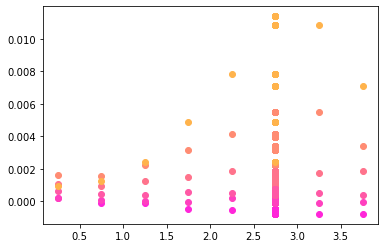

In [8]:
norm = mpl.colors.Normalize(vmin=8, vmax=13)
cmap = cm.spring
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for i, iz in enumerate(result_keys):
    for kk in stacked_flux_densities_dict[iz]['spire_plw']:
        z = (float(result_keys[i].split('-')[0])+float(result_keys[i].split('-')[1]))/2
        test_dict = stacked_flux_densities_dict[iz]['spire_plw']
        
        gal_type = 'sf'
        gal_key = [key for key, val in test_dict.items() if gal_type in key]
        gal_val = [val for key, val in test_dict.items() if gal_type in key]
        res = [val for key, val in test_dict.items() if gal_type in key]
        for i, imass in enumerate(gal_val):
            mass = (float(gal_key[i].split('_')[5].replace('p','.')) + float(gal_key[i].split('_')[6].replace('p','.')))/2
            plt.plot(z,imass['value'],'o',c=m.to_rgba(mass))

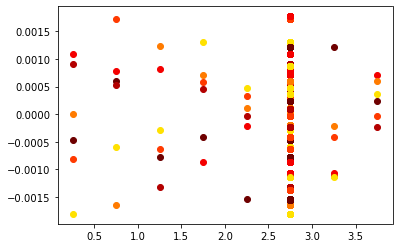

In [9]:
norm = mpl.colors.Normalize(vmin=8, vmax=13)
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for i, iz in enumerate(result_keys):
    for kk in stacked_flux_densities_dict[iz]['spire_plw']:
        z = (float(result_keys[i].split('-')[0])+float(result_keys[i].split('-')[1]))/2
        test_dict = stacked_flux_densities_dict[iz]['spire_plw']
        
        gal_type = 'dead'
        gal_key = [key for key, val in test_dict.items() if gal_type in key]
        gal_val = [val for key, val in test_dict.items() if gal_type in key]
        res = [val for key, val in test_dict.items() if gal_type in key]
        for i, imass in enumerate(gal_val):
            mass = (float(gal_key[i].split('_')[5].replace('p','.')) + float(gal_key[i].split('_')[6].replace('p','.')))/2
            plt.plot(z,imass['value'],'o',c=m.to_rgba(mass))